<a href="https://colab.research.google.com/github/pratikbariya/Read-the-printed-menus-using-yolo-and-OCR/blob/main/read_the_printed_menu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/m.v1i.yolov11.zip'
extract_path = '/content/drive/MyDrive/dataset'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted to: {extract_path}")

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11m.pt")

# To use already trained model
# model = YOLO("/content/best.pt")

# Train the model
results = model.train(
    data="/content/drive/MyDrive/dataset/data.yaml",
    epochs=100,
    imgsz=640,
    # batch=8,               # Recommended for small data/GPU
    # lr0=0.001,             # Optional: lower LR if overfitting
    # device=0,              # Use GPU if available
    save=True,
    # save_period=5,
    # val=True,
    # patience=20,           # Early stopping: stops if no improvement
    # plots=True,
    # workers=2              # Reduce workers for Colab stability
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!pip install pytesseract


0: 640x640 7 descriptions, 18 items, 19 prices, 18 tittles, 1394.1ms
Speed: 5.8ms preprocess, 1394.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/MyDrive/predicted
Sample Image


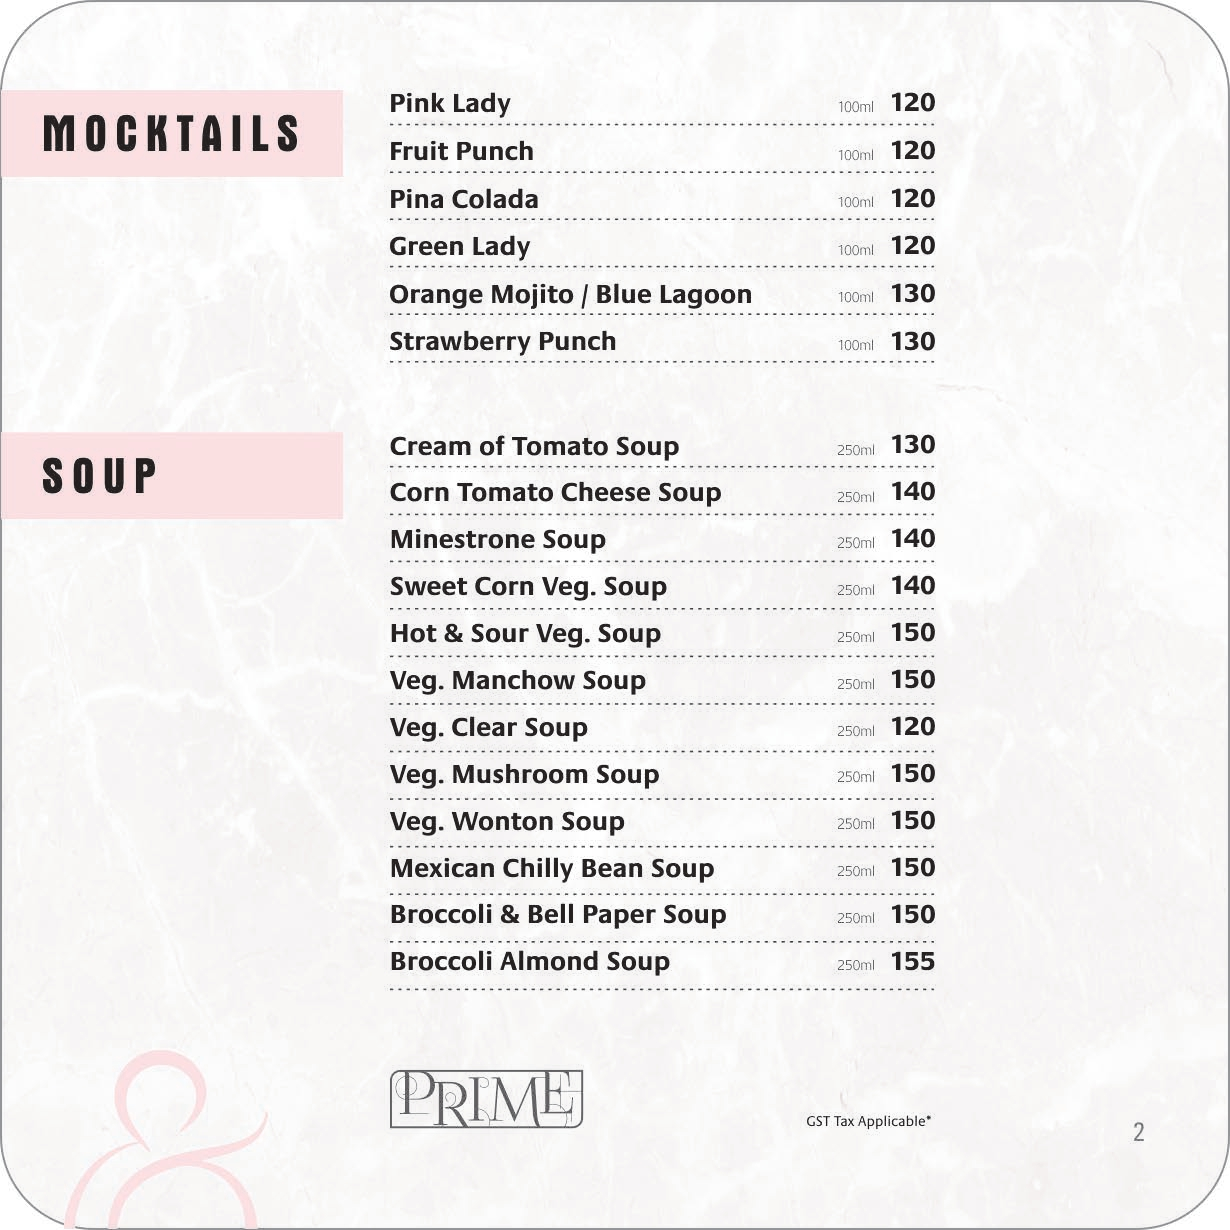

Result Image


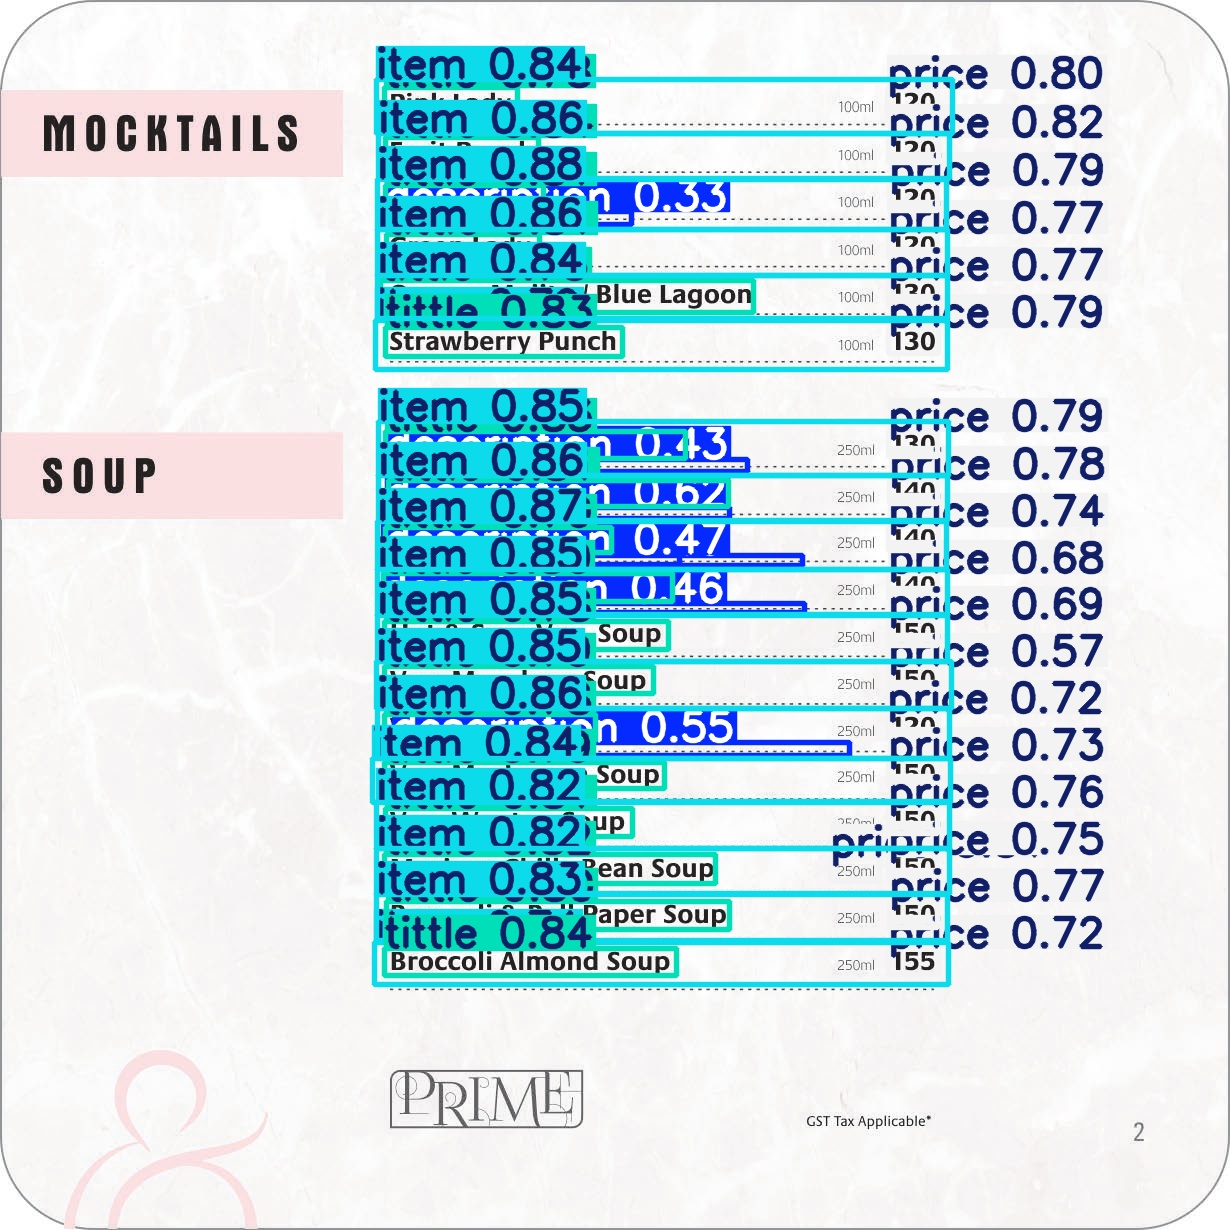

Resulted Json
[
  {
    "tittle":"Broccoli Almond Soup",
    "price":"155"
  },
  {
    "tittle":"Fruit Punch",
    "price":"120"
  },
  {
    "tittle":"Cream of Tomato Soup",
    "price":"130"
  },
  {
    "tittle":"Strawberry Punch",
    "price":"130"
  },
  {
    "tittle":"Mexican Chilly Bean Soup",
    "price":"250"
  },
  {
    "tittle":"Pina Colada",
    "price":"120"
  },
  {
    "tittle":"Corn Tomato Cheese Soup",
    "price":"140"
  },
  {
    "tittle":"Veg. Wonton Soup",
    "price":"150"
  },
  {
    "tittle":"Green Lady",
    "price":"120"
  },
  {
    "tittle":"Sweet Corn Veg. Soup",
    "price":"140"
  },
  {
    "tittle":"Pink Lady",
    "price":"120"
  },
  {
    "tittle":"Broccoli & Bell Paper Soup",
    "price":"150"
  },
  {
    "tittle":"Veg. Manchow Soup",
    "price":"150"
  },
  {
    "tittle":"Minestrone Soup",
    "price":"140"
  },
  {
    "tittle":"Veg. Mushroom Soup",
    "price":"150"
  },
  {
    "tittle":"Veg. Clear Soup",
    "price":"120"
  },
  {
    "

In [48]:
import cv2, pytesseract, re, pandas as pd
from IPython.display import Image
import numpy as np
from sklearn.cluster import DBSCAN
import cv2, pytesseract, pandas as pd, re
from collections import defaultdict

img = cv2.imread('/content/food-menu-2024_page-0003.jpg')

result = model.predict(
    img,
    save=True,
    project="/content/drive/MyDrive/",
    name='predicted', # create folder at content.
    exist_ok=True,
    # hide_labels=True, # remove the label from the result
    show_boxes=True # remove bounding box from the result.
)


def ocr_crop(crop, whitelist=None):
    rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    cfg = '--psm 7' + (f' -c tessedit_char_whitelist={whitelist}' if whitelist else '')
    text = pytesseract.image_to_string(rgb, config=cfg).strip()
    return text

def yolo2table(result):
    img   = result.orig_img
    boxes = result.boxes.xyxy.cpu().numpy()
    clss  = result.boxes.cls.int().cpu().numpy()
    names = {k: v.lower() for k, v in result.names.items()}
    rows = defaultdict(dict)

    # Step 1: Cluster Y positions using DBSCAN to determine logical rows
    y_centers = np.array([[(y1 + y2) / 2] for (x1, y1, x2, y2) in boxes])
    clustering = DBSCAN(eps=15, min_samples=1).fit(y_centers)
    bands = clustering.labels_

    # Step 2: Process each detection
    for ((x1, y1, x2, y2), cls_id, band) in zip(boxes, clss, bands):
        crop = img[int(y1):int(y2), int(x1):int(x2)]
        cls  = names[cls_id]

        if cls == 'price':
            text = ocr_crop(crop)
            text = re.search(r'[\d,.]+', text)
            text = text.group(0) if text else ''
        elif cls == 'tittle':
            text = ocr_crop(crop)
        else:
            continue
        # print(text, band)
        rows[band][cls] = text


    # Step 3: Convert to DataFrame
    df = (pd.DataFrame.from_dict(rows, orient='index')
          .reindex(columns=['tittle', 'price'])
          .dropna(how='all'))

    return df


# -------- 3. run it ---------------------------------
df = yolo2table(result[0])    # results is the list you got from model.predict
df.to_csv('menu_extracted.csv', index=False)

print("Sample Image")
display(Image("/content/food-menu-2024_page-0003.jpg", width=700, height=1000))

print("Result Image")
display(Image("/content/drive/MyDrive/predicted/image0.jpg", width=700, height=1000))

print("Resulted Json")
json_output = df.to_json(indent=2, orient="records")
print(json_output)